# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/ololpol/ScalML/lab1/mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 12, 17, 10, 848763)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-18 12:17:10,890 INFO: Initializing external client
2025-11-18 12:17:10,891 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 12:17:11,791 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 12:17:12,826 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279181


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_lag",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-18 12:17:18,143 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/547780 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/115872 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26225 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.1914045E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

air_quality_fg = fs.get_feature_group(
    name='air_quality_lag',
    version=1,
)

aq_today = air_quality_fg.filter(air_quality_fg.date >= yesterday).read()
batch_data = weather_fg.filter(weather_fg.date >= today).read()

lag1 = aq_today["pm25_lag1"]
lag2 = aq_today["pm25_lag2"]
lag3 = aq_today["pm25_lag3"]
batch_data["pm25_lag1"] = 0
batch_data["pm25_lag2"] = 0
batch_data["pm25_lag3"] = 0
batch_data['predicted_pm25'] = 0

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.70s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 


In [8]:
df_values = ["pm25_lag1", "pm25_lag2", "pm25_lag3",'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
#batch_data['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', "pm25_lag1", "pm25_lag2", "pm25_lag3"][0]
#batch_data[0:1][df_values]


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [9]:
for i in range(len(batch_data)):
    batch_data["pm25_lag1"][i] = lag1
    batch_data["pm25_lag2"][i] = lag2
    batch_data["pm25_lag3"][i] = lag3
    res = retrieved_xgboost_model.predict(batch_data[df_values][i:i+1])
    lag3 = lag2
    lag2 = lag1
    lag1 = res
    batch_data["predicted_pm25"][i] = res
    

batch_data


2025-11-18 12:17:27,877 WARNING: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2025-11-18 12:17:27,881 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25
0,2025-11-19 00:00:00+00:00,-1.25,0.1,7.172949,17.525669,Uppsala,13.000000,22.000000,31.000000,22.246290
1,2025-11-20 00:00:00+00:00,-2.05,0.0,12.727921,331.260284,Uppsala,22.246290,13.000000,22.000000,15.358972
2,2025-11-21 00:00:00+00:00,-4.65,0.0,8.557102,284.620911,Uppsala,15.358972,22.246290,13.000000,21.707293
3,2025-11-22 00:00:00+00:00,1.75,0.0,18.875126,235.097427,Uppsala,21.707293,15.358972,22.246290,25.824291
4,2025-11-23 00:00:00+00:00,1.60,0.0,7.421590,165.963730,Uppsala,25.824291,21.707293,15.358972,31.323109
5,2025-11-24 00:00:00+00:00,1.55,0.4,11.525623,194.470337,Uppsala,31.323109,25.824291,21.707293,22.966610


In [10]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   pm25_lag1                    6 non-null      float64                
 7   pm25_lag2                    6 non-null      float64                
 8   pm25_lag3                    6 non-null      float64                
 9   predicted_pm25               6 non-null      float64                
dtypes: dat

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [11]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,-1.25,0.1,7.172949,17.525669,Uppsala,13.000000,22.000000,31.000000,22.246290,Kungsgatan-67,Sweden,1
1,2025-11-20 00:00:00+00:00,-2.05,0.0,12.727921,331.260284,Uppsala,22.246290,13.000000,22.000000,15.358972,Kungsgatan-67,Sweden,2
2,2025-11-21 00:00:00+00:00,-4.65,0.0,8.557102,284.620911,Uppsala,15.358972,22.246290,13.000000,21.707293,Kungsgatan-67,Sweden,3
3,2025-11-22 00:00:00+00:00,1.75,0.0,18.875126,235.097427,Uppsala,21.707293,15.358972,22.246290,25.824291,Kungsgatan-67,Sweden,4
4,2025-11-23 00:00:00+00:00,1.60,0.0,7.421590,165.963730,Uppsala,25.824291,21.707293,15.358972,31.323109,Kungsgatan-67,Sweden,5
5,2025-11-24 00:00:00+00:00,1.55,0.4,11.525623,194.470337,Uppsala,31.323109,25.824291,21.707293,22.966610,Kungsgatan-67,Sweden,6


In [12]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   pm25_lag1                    6 non-null      float64                
 7   pm25_lag2                    6 non-null      float64                
 8   pm25_lag3                    6 non-null      float64                
 9   predicted_pm25               6 non-null      float64                
 10  street

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-18 12:17:28,132 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



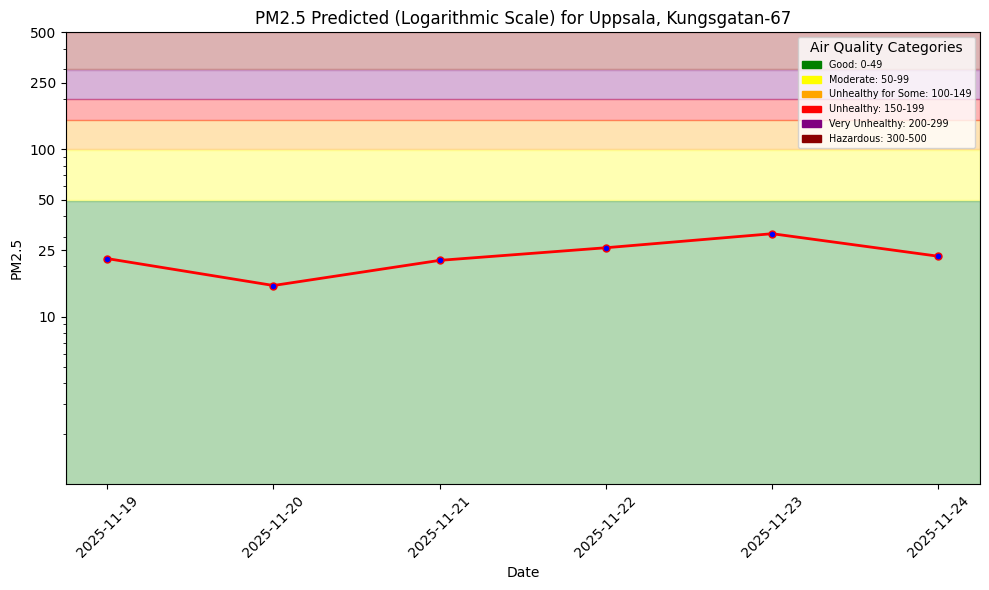

In [13]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [14]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_lag',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [15]:
monitor_fg.insert(batch_data, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279181/fs/1265799/fg/1721950


Uploading Dataframe: 100.00% |███████████████████████████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_lag_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279181/jobs/named/aq_predictions_lag_1_offline_fg_materialization/executions
2025-11-18 12:17:49,396 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 12:17:52,568 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 12:19:31,407 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 12:19:31,582 INFO: Waiting for log aggregation to finish.
2025-11-18 12:19:43,827 INFO: Execution finished successfully.


(Job('aq_predictions_lag_1_offline_fg_materialization', 'SPARK'), None)

In [16]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.79s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag1,pm25_lag2,pm25_lag3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,-1.25,0.1,7.172949,17.525669,Uppsala,13.0,22.0,31.0,22.24629,Kungsgatan-67,Sweden,1


In [17]:
air_quality_fg = fs.get_feature_group(name='air_quality_lag', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.16s) 


,date,pm25,pm25_lag1,pm25_lag2,pm25_lag3,country,city,street,url
0,2025-10-23 00:00:00+00:00,56.0,34.0,21.0,27.0,Sweden,Uppsala,Kungsgatan-67,https://api.waqi.info/feed/@10015
1,2023-12-13 00:00:00+00:00,16.0,12.0,20.0,14.0,Sweden,Uppsala,Kungsgatan-67,https://api.waqi.info/feed/@10015
2,2023-01-13 00:00:00+00:00,13.0,13.0,10.0,8.0,Sweden,Uppsala,Kungsgatan-67,https://api.waqi.info/feed/@10015
3,2025-10-10 00:00:00+00:00,13.0,13.0,6.0,7.0,Sweden,Uppsala,Kungsgatan-67,https://api.waqi.info/feed/@10015
4,2019-06-24 00:00:00+00:00,13.0,16.0,29.0,28.0,Sweden,Uppsala,Kungsgatan-67,https://api.waqi.info/feed/@10015
...,...,...,...,...,...,...,...,...,...
2929,2020-04-30 00:00:00+00:00,28.0,34.0,23.0,17.0,Sweden,Uppsala,Kungsgatan-67,https://api.waqi.info/feed/@10015
2930,2018-03-29 00:00:00+00:00,39.0,24.0,27.0,44.0,Sweden,Uppsala,Kungsgatan-67,https://api.waqi.info/feed/@10015
2931,2022-06-24 00:00:00+00:00,17.0,25.0,27.0,38.0,Sweden,Uppsala,Kungsgatan-67,https://api.waqi.info/feed/@10015
2932,2020-07-30 00:00:00+00:00,11.0,17.0,27.0,23.0,Sweden,Uppsala,Kungsgatan-67,https://api.waqi.info/feed/@10015


In [20]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
#if len(hindcast_df) == 0:
#    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

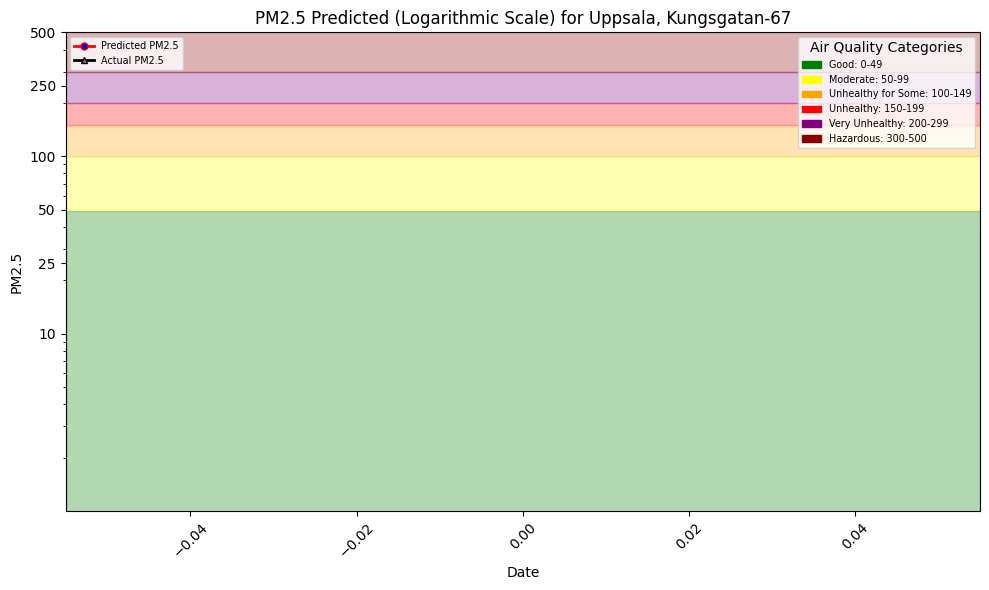

In [21]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [22]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /home/ololpol/ScalML/lab1/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|          …

Uploading /home/ololpol/ScalML/lab1/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%|     …

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279181/settings/fb/path/Resources/airquality


---